In [1]:
import os
import glob
import re
import numpy as np
import numpy.fft as fft
import mne
import matplotlib.pyplot as plt
from scipy import stats, signal
from numpy import save, load
import pandas as pd
import sklearn
from imblearn.over_sampling import SMOTE 
from sklearn.svm import SVC


In [2]:
import imblearn

### read dataset X and Y

In [3]:
def read_patient_file(base_path,subject_id,fileno):

    X=load('{}/data_chb{:02d}/features_{}_{:02d}.npy'.format(base_path,subject_id,subject_id, fileno))
    y=load('{}/data_chb{:02d}/targets_{}_{:02d}.npy'.format(base_path,subject_id,subject_id, fileno))
    
    return X,y

In [4]:
# selected_files_train={1:[2,10,14,15,17,20,30],3:[0,1,2,3,33,34,11,16],7:[11,12,2],8:[0,3,5,7,12],10:[16,19,23,1],5:[5,12,15,30], 15:[14,24,31,35,27],22:[16,21,4]}
# selected_files_test={1:[25,27],3:[35,27],7:[18,16],8:[15,19],10:[24,13],5:[21,36],15:[38],22:[27,24], 9:[10,5,6,7,11]}

In [5]:
ages={1:11,2:11,3:14,4:22,5: 7,6: 1.5,7:14.5,8: 3.5,9:10,10: 3,11:12,12: 2,13: 3,14: 9,15:16,16: 7,17:12,18:18,19:19,20: 6,21:13,22: 9,23: 6}

In [6]:
list(ages.values())[-1]

6

In [7]:
file_info=pd.read_csv('file_info.csv')
file_info[['day','night']]

,day,night
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False
...,...,...
628,True,False
629,True,False
630,True,False
631,False,True


In [8]:
# 
#  selected_files_train={1:[2,10,14,15,17,20,30],3:[0,10],7:[11,2],8:[0,11],10:[21,23,1,3],5:[5,12,15,30],9:[1,5], 15:[0,28],22:[16,1],23:[7,3],17:[18,0],18:[0,34]}
    # selected_files_test={1:[25,29],3:[33,12],7:[18,3],8:[15,19],10:[16,19,0,2],5:[21,36],15:[4,26],22:[27,0], 9:[18,13],23:[0,8],17:[19,9],18:[1,28]} 
def read_data(base_path,patients, test=False):
    time_df=pd.DataFrame(columns=['day','night'])
    selected_files_test={1:[2,10,14,15,17,20,30],3:[0,1,2,3,34,11,16],7:[11,2],8:[0,11],10:[21,23,1,3],5:[5,12,15,30],9:[1,5], 15:[0,28],22:[16,1],23:[7,3],17:[18,0],18:[0,34]}
    selected_files_train={1:[25,29],3:[33,12],7:[18,3],8:[15,19],10:[16,19,0,2],5:[21,36],15:[4,26],22:[27,0], 9:[18,13],23:[0,8],17:[19,9],18:[1,28]}   
    file_dict={}
    fileidx=0
    if test:
        selected_files_train=selected_files_test
    print(base_path,patients[0],selected_files_train[patients[0]][0])
    Xnp,ynp=read_patient_file(base_path,patients[0],selected_files_train[patients[0]][0])
    # time_df = pd.concat([time_df,file_info[(file_info['patient']==patients[0]) & (file_info['file_processed']==selected_files_train[patients[0]][0])][['day','night']]],sort=False)
    day=np.ones_like(ynp)
    night=np.ones_like(ynp)
    day=day*int(file_info[(file_info['patient']==patients[0]) & (file_info['file_processed']==selected_files_train[patients[0]][0])]['day'])
    night=night*int(file_info[(file_info['patient']==patients[0]) & (file_info['file_processed']==selected_files_train[patients[0]][0])]['night'])
    file_dict[fileidx]=len(Xnp)
    fileidx+=1
    for fileno1 in selected_files_train[patients[0]][1:]:
        X_add, y_add= read_patient_file(base_path,patients[0],fileno1)
        Xnp=np.concatenate((Xnp,X_add))
        ynp=np.concatenate((ynp,y_add))
        file_dict[fileidx]=len(Xnp)
        # time_df = pd.concat([time_df,file_info[(file_info['patient']==patients[0]) & (file_info['file_processed']==fileno1)][['day','night']]],sort=False)
        night_add=np.ones_like(y_add)
        day_add=np.ones_like(y_add)
        day_add=day_add*int(file_info[(file_info['patient']==patients[0]) & (file_info['file_processed']==fileno1)]['day'])
        night_add=night_add*int(file_info[(file_info['patient']==patients[0]) & (file_info['file_processed']==fileno1)]['night'])
        day=np.concatenate((day,day_add))
        night=np.concatenate((night,night_add))
        print(len(ynp))
        fileidx+=1
    for subject_id in (patients[1:]):
        for fileno in (selected_files_train[subject_id]):
                X_add, y_add= read_patient_file(base_path,subject_id,fileno)
                print(X_add.shape)
                Xnp=np.concatenate((Xnp,X_add))
                ynp=np.concatenate((ynp,y_add))
                file_dict[fileidx]=len(Xnp)
                # time_df = pd.concat([time_df,file_info[(file_info['patient']==subject_id) & (file_info['file_processed']==fileno)][['day','night']]],sort=False)
                night_add=np.ones_like(y_add)
                day_add=np.ones_like(y_add)
                day_add=day_add*int(file_info[(file_info['patient']==patients[0]) & (file_info['file_processed']==fileno)]['day'])
                night_add=night_add*int(file_info[(file_info['patient']==patients[0]) & (file_info['file_processed']==fileno)]['night'])
                day=np.concatenate((day,day_add))
                night=np.concatenate((night,night_add))
                fileidx+=1
    time_df['day']=day
    time_df['night']=night

    return Xnp,ynp, file_dict, time_df
    


In [9]:
X_train,y_train, files_train, train_time_df=read_data('nodiff_normalised_10',[1,3,5,7,8,10,22])
print(X_train.shape,y_train.shape,train_time_df.shape)
# Xsum_train,ysum_train, sumfiles_train=read_data('sum_10',[1,3,5,7,8,10,22])
# print(Xsum_train.shape,ysum_train.shape)

nodiff_normalised_10 1 25
1175
(713, 208)
(718, 208)
(712, 208)
(718, 208)
(2873, 208)
(2878, 208)
(712, 208)
(723, 208)
(1433, 208)
(1434, 208)
(1442, 208)
(1438, 208)
(712, 208)
(718, 208)
(18399, 208) (18399,) (18399, 2)


In [10]:
files_train

{0: 457,
 1: 1175,
 2: 1888,
 3: 2606,
 4: 3318,
 5: 4036,
 6: 6909,
 7: 9787,
 8: 10499,
 9: 11222,
 10: 12655,
 11: 14089,
 12: 15531,
 13: 16969,
 14: 17681,
 15: 18399}

In [11]:
train_time_df

,day,night
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
18394,1,0
18395,1,0
18396,1,0
18397,1,0


In [12]:
    def generate_column_names():
        channel_order= {'FP1-F7':0, 'F7-T7':1, 'T7-P7':2, 'P7-O1':3, 'FP1-F3':4, 'F3-C3':5, 'C3-P3':6, 'P3-O1':7, 'FP2-F4':8, 'F4-C4':9, 'C4-P4':10, 'P4-O2':11, 'FP2-F8':12, 'F8-T8':13, 'T8-P8-0':14, 'P8-O2':15, 'FZ-CZ':16, 'CZ-PZ':17, 'P7-T7':18, 'T7-FT9':19, 'FT9-FT10':20, 'FT10-T8':21 ,'T8-P8-1':22 }
        # channel_order= {0:'FP1-F7', 1:'F7-T7', 2:'T7-P7', 3:'P7-O1', 4:'FP1-F3', 5:'F3-C3', 6:'C3-P3', 7:'P3-O1', 8:'FP2-F4', 9:'F4-C4', 10:'C4-P4', 11:'P4-O2', 12:'FP2-F8', 13:'F8-T8', 14:'T8-P8', 15:'P8-O2', 16:'FZ-CZ', 17:'CZ-PZ', 18:'P7-T7', 19:'T7-FT9', 20:'FT9-FT10', 21:'FT10-T8' ,22:'T8-P8' }
        col_names=[]
        for ch in channel_order:
            # print(ch)
            for i in range(0,9):
                col_names.append(str(ch)+'-'+str(i))
        # col_names.append('rms')
        # col_names.append('sum')
        col_names.append('patient')
        # print(col_names.shape)
        return col_names


In [13]:
# df_sums =pd.DataFrame(data=Xsum_train , columns=['sum', 'rms', 'patient'])
# df_sums

In [14]:
df=pd.DataFrame(data=X_train, columns=generate_column_names())

df=df.drop(['T8-P8-1-0', 'T8-P8-1-1', 'T8-P8-1-2', 'T8-P8-1-3', 'T8-P8-1-4', 'T8-P8-1-5', 'T8-P8-1-6', 'T8-P8-1-7', 'T8-P8-1-8'], axis=1)
# df['sum']=df_sums['sum']
# df['rms']=df_sums['rms']
# df['patient']=df_sums['patient']
# df=df[['FP2-F8-6','FP2-F8-1']]

# df=df.drop(['P8-O2-4','P3-O1-5','FZ-CZ-0','FP2-F8-4','P7-O1-4','FT9-FT10-5','FP1-F3-0','F4-C4-0','C3-P3-0','FP1-F3-3',
# 'C4-P4-3','FP1-F7-1','P8-O2-1','P4-O2-1','F7-T7-1','T7-FT9-2','P4-O2-3','P8-O2-3','P7-O1-1','P4-O2-0','T7-FT9-1','P8-O2-0','F8-T8-1','T7-FT9-3','T7-FT9-0','FP2-F8-1'], axis=1)

# df['age1']=df['patient'].apply(lambda x:ages[x]>10)
# df['age2']=df['patient'].apply(lambda x:ages[x]<=10)
df['day']=train_time_df['day']
df['night']=train_time_df['night']
df['target']=y_train
df['file']=files_train[0]
for i in range(1,len(files_train)):
    print(files_train[i])
    df['file'][max(0, files_train[i-1]):files_train[i]]=files_train[i]
print(df.shape)
df=df.dropna()
print(df.shape)
df.reset_index(drop=True, inplace=True)

1175
1888
2606
3318
4036
6909
9787
10499
11222
12655
14089
15531
16969
17681
18399
(18399, 203)
(18396, 203)


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
# df['file']=files_train[0]
# df['file'].unique()

In [16]:
df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,day,night,target,file
0,0.017723,0.020211,0.768304,0.099957,0.014016,0.000494,0.001850,0.000448,2037.888062,0.026709,...,0.011617,0.000553,0.002275,0.000274,651.385864,1.0,1,0,3,457
1,0.031132,0.046605,0.731898,0.097229,0.034401,0.003427,0.007990,0.000992,3224.813965,0.044682,...,0.020855,0.001460,0.007956,0.001468,677.824341,1.0,1,0,3,457
2,0.035133,0.051371,0.757499,0.105475,0.038017,0.003821,0.008802,0.001086,2828.295166,0.040258,...,0.018728,0.001615,0.008290,0.001737,858.115173,1.0,1,0,3,457
3,0.036837,0.026639,0.810234,0.179869,0.011366,0.000411,0.001503,0.000262,780.482117,0.060336,...,0.013661,0.001062,0.004456,0.000959,552.903503,1.0,1,0,3,457
4,0.025464,0.071755,0.635530,0.106590,0.092447,0.003513,0.013194,0.002597,1326.567017,0.042704,...,0.014078,0.000987,0.004666,0.000745,661.807800,1.0,1,0,3,457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18391,0.006616,0.012602,0.846233,0.055917,0.017945,0.001448,0.004585,0.001758,3873.622803,0.021709,...,0.269659,0.057637,0.168672,0.038558,447.624023,22.0,1,0,0,18399
18392,0.009072,0.019281,0.869771,0.045391,0.018978,0.001093,0.002300,0.000437,1798.684814,0.021304,...,0.105904,0.027436,0.126820,0.007391,161.192459,22.0,1,0,0,18399
18393,0.012089,0.014924,0.865622,0.093089,0.016280,0.000814,0.001868,0.000406,2097.132324,0.024189,...,0.094006,0.024201,0.107821,0.005054,169.873901,22.0,1,0,0,18399
18394,0.009635,0.015265,0.878467,0.098074,0.018569,0.000775,0.002347,0.000368,2097.160156,0.032543,...,0.112400,0.023424,0.099080,0.005962,154.879822,22.0,1,0,0,18399


In [17]:
X_test,y_test,files_test, test_time_df=read_data('nodiff_normalised_10',[1,3,5,7,8,10,22,9,23,17,18], test=True)
print(X_test.shape,y_test.shape)
# Xsum_test,ysum_test, sumfiles_test=read_data('sum_10',[1,3,5,7,8,10,22,9,23,17,18],test=True)
# print(Xsum_test.shape,ysum_test.shape)

nodiff_normalised_10 1 2
1525
2237
2951
3665
4379
5097
(715, 208)
(712, 208)
(714, 208)
(713, 208)
(712, 208)
(718, 208)
(718, 208)
(714, 208)
(715, 208)
(712, 208)
(718, 208)
(2871, 208)
(2878, 208)
(714, 208)
(718, 208)
(1435, 208)
(1430, 208)
(1438, 208)
(1438, 208)
(712, 208)
(718, 208)
(2878, 208)
(2870, 208)
(2878, 208)
(2866, 208)
(718, 208)
(712, 208)
(780, 208)
(1007, 208)
(42019, 208) (42019,)


In [18]:
# test_df_sums =pd.DataFrame(data=Xsum_test , columns=['sum', 'rms', 'patient'])
# test_df_sums

In [19]:
test_df=pd.DataFrame(data=X_test, columns=generate_column_names())

test_df=test_df.drop(['T8-P8-1-0', 'T8-P8-1-1', 'T8-P8-1-2', 'T8-P8-1-3', 'T8-P8-1-4', 'T8-P8-1-5', 'T8-P8-1-6', 'T8-P8-1-7', 'T8-P8-1-8'], axis=1)

# test_df['sum']=test_df_sums['sum']
# test_df['rms']=test_df_sums['rms']
# test_df=test_df[['FP2-F8-6','FP2-F8-1']]
# test_df=test_df.drop(['P8-O2-4','P3-O1-5','FZ-CZ-0','FP2-F8-4','P7-O1-4','FT9-FT10-5','FP1-F3-0','F4-C4-0','C3-P3-0','FP1-F3-3',
# 'C4-P4-3','FP1-F7-1','P8-O2-1','P4-O2-1','F7-T7-1','T7-FT9-2','P4-O2-3','P8-O2-3','P7-O1-1','P4-O2-0','T7-FT9-1','P8-O2-0','F8-T8-1','T7-FT9-3','T7-FT9-0','FP2-F8-1'], axis=1)
# test_df['age1']=test_df['patient'].apply(lambda x:ages[x]>10)
# test_df['age2']=test_df['patient'].apply(lambda x:ages[x]<=10)
test_df['day']=test_time_df['day']
test_df['night']=test_time_df['night']
test_df['target']=y_test
test_df['file']=files_test[0]
for i in range(1,len(files_test)):
    print(files_test[i])
    test_df['file'][max(0, files_test[i-1]):files_test[i]]=files_test[i]
print(test_df.shape)
test_df=test_df.dropna()
print(test_df.shape)
test_df.reset_index(drop=True, inplace=True)


1525
2237
2951
3665
4379
5097
5812
6524
7238
7951
8663
9381
10099
10813
11528
12240
12958
15829
18707
19421
20139
21574
23004
24442
25880
26592
27310
30188
33058
35936
38802
39520
40232
41012
42019
(42019, 203)
(42019, 203)


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
test_df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,day,night,target,file
0,0.317453,0.056905,0.484884,0.202054,0.009336,0.000199,0.001357,0.000087,681.910217,0.105987,...,0.016756,0.000791,0.005094,0.000206,2.310712e+02,1.0,1,0,3,807
1,0.260220,0.042801,0.544051,0.214271,0.006319,0.000154,0.001021,0.000058,1016.223938,0.107679,...,0.013836,0.000612,0.003989,0.000179,2.673471e+02,1.0,1,0,3,807
2,0.283113,0.047372,0.527044,0.197292,0.007341,0.000194,0.001247,0.000074,875.282532,0.125515,...,0.014234,0.000874,0.005550,0.000192,2.295485e+02,1.0,1,0,3,807
3,0.217460,0.038672,0.623639,0.148694,0.009089,0.000184,0.001148,0.000071,755.889526,0.091889,...,0.017835,0.000844,0.005493,0.000195,2.068311e+02,1.0,1,0,3,807
4,0.203887,0.022272,0.554251,0.263902,0.007212,0.000379,0.002090,0.000441,1298.831787,0.088905,...,0.008808,0.000400,0.002528,0.000225,4.695169e+02,1.0,1,0,3,807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42014,0.137320,0.356451,0.086383,0.117785,0.234170,0.051508,0.015634,0.036518,261834.890625,0.139662,...,0.074773,0.035117,0.037366,0.024852,4.983582e+07,18.0,0,1,0,42019
42015,0.087026,0.248776,0.053297,0.073225,0.217767,0.131693,0.123627,0.052878,800284.000000,0.118501,...,0.102777,0.044869,0.058577,0.052582,5.462357e+07,18.0,0,1,0,42019
42016,0.088255,0.251706,0.054128,0.074294,0.218880,0.130040,0.120499,0.051587,820610.000000,0.119469,...,0.084524,0.041924,0.048593,0.036209,6.005514e+07,18.0,0,1,0,42019
42017,0.134045,0.349760,0.084285,0.114859,0.233738,0.056575,0.021761,0.037499,352957.687500,0.181893,...,0.079817,0.033802,0.030667,0.019489,5.725523e+07,18.0,0,1,0,42019


In [21]:
df['file'].unique()

array([  457,  1175,  1888,  2606,  3318,  4036,  6909,  9787, 10499,
       11222, 12655, 14089, 15531, 16969, 17681, 18399], dtype=int64)

In [22]:
test_df['file'].unique()

array([  807,  1525,  2237,  2951,  3665,  4379,  5097,  5812,  6524,
        7238,  7951,  8663,  9381, 10099, 10813, 11528, 12240, 12958,
       15829, 18707, 19421, 20139, 21574, 23004, 24442, 25880, 26592,
       27310, 30188, 33058, 35936, 38802, 39520, 40232, 41012, 42019],
      dtype=int64)

In [23]:
# check_df=pd.merge(test_df,df, how='inner', on='F7-T7-0')
# check_df

In [24]:
# test_df['FP1-F7-2'].duplicated().sum()

In [25]:
test_df[test_df['target']==2]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,day,night,target,file
478,0.060544,0.054640,0.653075,0.305945,0.018844,0.000461,0.002765,0.000179,336.023499,0.044030,...,0.017914,0.000580,0.003237,0.000247,186.223602,1.0,1,0,2,807
479,0.053987,0.061336,0.599185,0.323933,0.022026,0.000674,0.003901,0.000237,286.529877,0.074399,...,0.016983,0.000675,0.003737,0.000231,182.042557,1.0,1,0,2,807
480,0.047027,0.074372,0.621275,0.310616,0.020787,0.000678,0.004019,0.000240,284.721130,0.046245,...,0.021470,0.000832,0.005127,0.000257,159.604324,1.0,1,0,2,807
481,0.045729,0.105353,0.659970,0.276229,0.024385,0.000804,0.004702,0.000289,243.630539,0.039519,...,0.027531,0.001135,0.006873,0.000287,140.039597,1.0,1,0,2,807
482,0.060507,0.097700,0.629019,0.257606,0.023562,0.000803,0.004503,0.000303,244.437820,0.036771,...,0.030450,0.001216,0.007004,0.000292,138.930389,1.0,1,0,2,807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41098,0.183028,0.059549,0.524906,0.345812,0.011892,0.000727,0.002643,0.000729,89.957901,0.182331,...,0.043852,0.003853,0.023594,0.004453,62.293854,18.0,0,1,2,42019
41099,0.149578,0.066415,0.532459,0.334958,0.011231,0.000718,0.002615,0.000705,85.278900,0.166427,...,0.038364,0.004728,0.024536,0.004396,59.968960,18.0,0,1,2,42019
41100,0.127809,0.067758,0.604292,0.276538,0.018167,0.001106,0.004684,0.000881,97.785759,0.150409,...,0.053933,0.006983,0.034673,0.005840,44.486145,18.0,0,1,2,42019
41101,0.177025,0.063664,0.421916,0.478343,0.010318,0.000696,0.002697,0.000499,177.529526,0.122742,...,0.033666,0.003854,0.018222,0.003741,88.398689,18.0,0,1,2,42019


In [26]:
# df[generate_column_names()[:-10]].duplicated().sum()

In [27]:
df['file'].unique()

array([  457,  1175,  1888,  2606,  3318,  4036,  6909,  9787, 10499,
       11222, 12655, 14089, 15531, 16969, 17681, 18399], dtype=int64)

modifying preictal intervals

cleaning labels

In [28]:
for f in df['file'].unique():
    # print(f)
    temp_file_df=df[df['file']==f]
    if 2 in temp_file_df['target'].unique():
        # print(df[df['file']==f]['target'].unique())
        df['target'][(df['target']==0) & (df['file']==f)]=3
    # print(df[df['file']==f]['target'].unique())

for f in df['file'].unique():
    # print(f)
    temp_file_df=df[df['file']==f]
    if 2 in temp_file_df['target'].unique():
        for ind in range(temp_file_df.index.min(),temp_file_df.index.max()-1):
            # print('index'+str(ind)+"    "+str(len(temp_file_df)))
            if temp_file_df['target'].loc[ind]==2 and temp_file_df['target'].loc[ind+1]!=2:
                df['target'][ind+1:f]=3
        


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Py

Cleaning labels

In [29]:
for f in test_df['file'].unique():
    # print(f)
    temp_file_df=test_df[test_df['file']==f]
    if 2 in temp_file_df['target'].unique():
        # print(test_df[test_df['file']==f]['target'].unique())
        test_df['target'][(test_df['target']==0) & (test_df['file']==f)]=3
    # print(test_df[test_df['file']==f]['target'].unique())
    
for f in test_df['file'].unique():
    # print(f)
    temp_file_df=test_df[test_df['file']==f]
    if 2 in temp_file_df['target'].unique():
        for ind in range(temp_file_df.index.min(),temp_file_df.index.max()-1):
            if temp_file_df['target'].loc[ind]==2 and temp_file_df['target'].loc[ind+1]!=2:
                test_df['target'][ind+1:f]=3
        

C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Py

In [30]:
# for ind in df.index:
#     if df['target'].iloc[ind]==2 and df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (df['target'].iloc[i]==3 or df['target'].iloc[i]==3) and df['file'].iloc[i]==df['file'].iloc[ind]:
#                 # print(df[['target','file']].iloc[i])
#                 df.at[i,'target']=2

# for ind in df.index:
#     if df['target'].iloc[ind]==2 and df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (df['target'].iloc[i]==3 or df['target'].iloc[i]==3) and df['file'].iloc[i]==df['file'].iloc[ind]:
#                 # print(df[['target','file']].iloc[i])
#                 df.at[i,'target']=4

In [31]:
# for ind in test_df.index:
#     if test_df['target'].iloc[ind]==2 and test_df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (test_df['target'].iloc[i]==3 or test_df['target'].iloc[i]==3) and test_df['file'].iloc[i]==test_df['file'].iloc[ind]:
#                 # print(test_df[['target','file']].iloc[i])
#                 test_df.at[i,'target']=2

# for ind in test_df.index:
#     if test_df['target'].iloc[ind]==2 and test_df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (test_df['target'].iloc[i]==3 or test_df['target'].iloc[i]==3) and test_df['file'].iloc[i]==test_df['file'].iloc[ind]:
#                 # print(test_df[['target','file']].iloc[i])
#                 test_df.at[i,'target']=4

In [32]:
# df['ratio']= df['sum']/df['rms']
# test_df['ratio']= test_df['sum']/test_df['rms']


In [33]:
df['target'].unique()

array([3, 2, 0], dtype=int64)

In [34]:
df['target'][225:343].unique()

array([3, 2], dtype=int64)

In [35]:
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# data=df.drop(['patient','target','file'], axis=1)
# X = data[data.columns]

# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns

# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
# 						for i in range(len(X.columns))]

# print(vif_data)


In [36]:
# vif_data[vif_data['VIF']<50]['feature']

## Prepare training data

In [37]:
oneout=5

In [38]:
train_df=df
train_df=train_df[(train_df['target']==0) | (train_df['target']==2) | (train_df['target']==4)]
train_df=train_df[(train_df['patient']!=oneout)]
train_df=train_df[(train_df['patient']!=1)]

# train_df=train_df.drop(['patient'], axis=1)



In [39]:
train_df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,day,night,target,file
1450,0.103090,0.029230,0.740420,0.256889,0.001996,0.000223,0.000831,0.000119,533.303467,0.135195,...,0.002532,0.000189,0.000917,0.000207,325.062744,3.0,0,1,2,1888
1451,0.086338,0.018017,0.753868,0.245023,0.002612,0.000240,0.000979,0.000122,753.522949,0.073147,...,0.003906,0.000202,0.000906,0.000226,394.218445,3.0,0,1,2,1888
1452,0.073184,0.021159,0.750674,0.216456,0.009350,0.000889,0.003091,0.000396,282.884613,0.047420,...,0.012609,0.000723,0.003174,0.000834,127.400742,3.0,0,1,2,1888
1453,0.060463,0.027826,0.824375,0.140021,0.010757,0.000936,0.003181,0.000444,228.782974,0.044088,...,0.009211,0.000587,0.002805,0.000679,143.560730,3.0,0,1,2,1888
1454,0.052949,0.032759,0.826958,0.133002,0.012522,0.000890,0.003391,0.000532,217.149414,0.052273,...,0.008013,0.000504,0.002373,0.000620,154.491623,3.0,0,1,2,1888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18391,0.006616,0.012602,0.846233,0.055917,0.017945,0.001448,0.004585,0.001758,3873.622803,0.021709,...,0.269659,0.057637,0.168672,0.038558,447.624023,22.0,1,0,0,18399
18392,0.009072,0.019281,0.869771,0.045391,0.018978,0.001093,0.002300,0.000437,1798.684814,0.021304,...,0.105904,0.027436,0.126820,0.007391,161.192459,22.0,1,0,0,18399
18393,0.012089,0.014924,0.865622,0.093089,0.016280,0.000814,0.001868,0.000406,2097.132324,0.024189,...,0.094006,0.024201,0.107821,0.005054,169.873901,22.0,1,0,0,18399
18394,0.009635,0.015265,0.878467,0.098074,0.018569,0.000775,0.002347,0.000368,2097.160156,0.032543,...,0.112400,0.023424,0.099080,0.005962,154.879822,22.0,1,0,0,18399


## Prepare test data

In [40]:
# chunk_size=3
# test_files=test_df['file'].unique()
# print(test_files)
# test_indices=[]
# for f in test_files:
#     temp_df=test_df[test_df['file']==f]
#     test_idx=0
#     idx_limit=temp_df.index[0]
#     while test_idx+chunk_size<len(temp_df):
#         # print(temp_df.index[0])
#         test_indices.append((test_idx+idx_limit,idx_limit+test_idx+chunk_size))
#         test_idx+=chunk_size
# print(test_indices)
#         # test_chunks=np.concatenate((test_chunk,test_df[test_df['file']==test_files[0]][0:chunk_size]))

In [41]:
test_df[test_df['target']==2]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,day,night,target,file
478,0.060544,0.054640,0.653075,0.305945,0.018844,0.000461,0.002765,0.000179,336.023499,0.044030,...,0.017914,0.000580,0.003237,0.000247,186.223602,1.0,1,0,2,807
479,0.053987,0.061336,0.599185,0.323933,0.022026,0.000674,0.003901,0.000237,286.529877,0.074399,...,0.016983,0.000675,0.003737,0.000231,182.042557,1.0,1,0,2,807
480,0.047027,0.074372,0.621275,0.310616,0.020787,0.000678,0.004019,0.000240,284.721130,0.046245,...,0.021470,0.000832,0.005127,0.000257,159.604324,1.0,1,0,2,807
481,0.045729,0.105353,0.659970,0.276229,0.024385,0.000804,0.004702,0.000289,243.630539,0.039519,...,0.027531,0.001135,0.006873,0.000287,140.039597,1.0,1,0,2,807
482,0.060507,0.097700,0.629019,0.257606,0.023562,0.000803,0.004503,0.000303,244.437820,0.036771,...,0.030450,0.001216,0.007004,0.000292,138.930389,1.0,1,0,2,807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41098,0.183028,0.059549,0.524906,0.345812,0.011892,0.000727,0.002643,0.000729,89.957901,0.182331,...,0.043852,0.003853,0.023594,0.004453,62.293854,18.0,0,1,2,42019
41099,0.149578,0.066415,0.532459,0.334958,0.011231,0.000718,0.002615,0.000705,85.278900,0.166427,...,0.038364,0.004728,0.024536,0.004396,59.968960,18.0,0,1,2,42019
41100,0.127809,0.067758,0.604292,0.276538,0.018167,0.001106,0.004684,0.000881,97.785759,0.150409,...,0.053933,0.006983,0.034673,0.005840,44.486145,18.0,0,1,2,42019
41101,0.177025,0.063664,0.421916,0.478343,0.010318,0.000696,0.002697,0.000499,177.529526,0.122742,...,0.033666,0.003854,0.018222,0.003741,88.398689,18.0,0,1,2,42019


In [42]:
test_df2=test_df[(test_df['target']==0) | (test_df['target']==2) | (test_df['target']==4)]
test_df2=test_df2[(test_df2['patient']==oneout)]

In [43]:
test_df2

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,day,night,target,file
10099,0.029539,0.107215,0.614180,0.184045,0.082319,0.007210,0.033633,0.009339,5885.690918,0.022789,...,0.189352,0.022966,0.103992,0.032055,4430.769531,5.0,1,0,2,10813
10100,0.024412,0.016990,0.750970,0.292935,0.009110,0.000903,0.003616,0.000920,6755.720215,0.028967,...,0.062640,0.008624,0.047394,0.008892,2318.564941,5.0,1,0,2,10813
10101,0.017692,0.015294,0.763325,0.269427,0.009478,0.000464,0.001706,0.000473,12577.946289,0.019951,...,0.038870,0.006105,0.031100,0.005886,3305.057861,5.0,1,0,2,10813
10102,0.011544,0.016648,0.742480,0.248491,0.011873,0.000399,0.001408,0.000376,14984.622070,0.015031,...,0.047263,0.007637,0.036150,0.005900,2625.087891,5.0,1,0,2,10813
10103,0.009981,0.017273,0.758964,0.149193,0.012801,0.000366,0.001167,0.000191,18319.089844,0.023862,...,0.047767,0.007825,0.038680,0.004713,1566.368042,5.0,1,0,2,10813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12953,0.007782,0.002539,0.892619,0.072461,0.001862,0.000232,0.001304,0.000334,9828.911133,0.006096,...,0.014602,0.003374,0.017863,0.001372,3250.102051,5.0,1,0,0,12958
12954,0.006841,0.003176,0.864003,0.078754,0.002070,0.000291,0.001407,0.000409,7888.554688,0.009988,...,0.014137,0.003620,0.017995,0.001468,3065.759521,5.0,1,0,0,12958
12955,0.005352,0.003213,0.888925,0.075923,0.001970,0.000345,0.001347,0.000401,7777.488281,0.010351,...,0.016269,0.004762,0.022749,0.001821,2465.418701,5.0,1,0,0,12958
12956,0.007141,0.003298,0.919446,0.058201,0.001974,0.000351,0.001503,0.000406,6803.923340,0.010302,...,0.021815,0.006883,0.032877,0.002303,1628.409912,5.0,1,0,0,12958


In [44]:
test_df2['target'].unique()

array([2, 0], dtype=int64)

In [45]:
X_train1 = np.array(train_df.drop(['target','patient','file'], axis=1))
y_train1 = np.array(train_df['target'])
X_test1 = np.array(test_df2.drop(['target','patient','file'], axis=1)).astype('float32')
y_test1  =np.array(test_df2['target']).astype('float32')

In [46]:
# X_train1=np.array(train_df[vif_data[vif_data['VIF']<300000000]['feature']])
# X_test1=np.array(test_df2[vif_data[vif_data['VIF']<300000000]['feature']])

In [47]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train1, y_train1)
X_resampled_test, y_resampled_test = rus.fit_resample(X_test1, y_test1)


In [48]:
test_df.shape

(42019, 203)

In [49]:
X_train=np.array(X_resampled).astype('float32')
X_test=np.array( X_resampled_test).astype('float32')
y_train=np.array(y_resampled).astype('float32')
y_test=np.array( y_resampled_test).astype('float32')

X_train_shape =X_train.shape
X_test_shape = X_test.shape
y_train_shape =y_train.shape 
y_test_shape = y_test.shape
print(X_train_shape)
print(X_test_shape)
print(y_train_shape)
print(y_test_shape)

(1416, 200)
(636, 200)
(1416,)
(636,)


In [50]:
dfA=pd.DataFrame(data=X_train)
dfB=pd.DataFrame(data=X_test)
dfC=pd.concat([dfA,dfB])
dfC.shape

(2052, 200)

In [51]:
dfC[dfC.columns[-6]].duplicated().sum()

0

### Normalization

In [52]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# # scaler.fit(df.drop(['target', 'seizure_number', 'patient','mean_sum','mean_rms',	'sum_ratio','rms_ratio'], axis=1).append(test_df.drop(['target', 'seizure_number', 'patient','mean_sum','mean_rms',	'sum_ratio','rms_ratio'], axis=1), ignore_index=True))
# # scaler.fit(X_train)
Sc_X_train=scaler.fit_transform(X_train)
# # scaler.fit(X_test)
Sc_X_test=scaler.fit_transform(X_test)

In [53]:
X_train.shape

(1416, 200)

### PCA

In [54]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# Sc_X_train=pca.fit_transform(Sc_X_train)
# Sc_X_test=pca.transform(Sc_X_test)

### training the model

In [55]:
from datetime import datetime

In [56]:
cost: 150.0
weight_dict: {0: 1, 2: 10}

In [57]:
before = datetime.now()
before_time =before.strftime("%H:%M:%S")
print(before_time)

clf = SVC( C=1, kernel='rbf', random_state=42)
clf.fit(Sc_X_train, y_train)
trainAcc = clf.score(Sc_X_train, y_train)
testAcc = clf.score(Sc_X_test, y_test)
print("**SVM Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

after = datetime.now()
after_time =after.strftime("%H:%M:%S")
print(after_time)

21:00:09
**SVM Results:**
Training Accuracy: 98%
Testing Accuracy: 80%
21:00:09


In [58]:
import joblib


# # print ("saving new model")
# joblib.dump(clf,"my_models/temporal{}_{}_{}.pkl".format(after_time[0:2],after_time[3:5],"f189"))

In [59]:
# clf = joblib.load("my_models/temporal00_54_C.pkl")
# y_pred=loaded_clf.predict(X_test)
y_pred=clf.predict(scaler.fit_transform(X_test))

In [60]:
def smooth(ser):
    window=7
    i=0
    while i < len(ser)-window:
        if ser[i]==ser[i+window]:
            ser[i:i+window]=ser[i]
        i+=1
    return np.array(ser)
clf.get_params(deep=True)

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [61]:
print(sklearn.metrics.classification_report(y_test, y_pred,))

              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       318
         2.0       1.00      0.62      0.77       318

    accuracy                           0.81       636
   macro avg       0.86      0.81      0.80       636
weighted avg       0.86      0.81      0.80       636



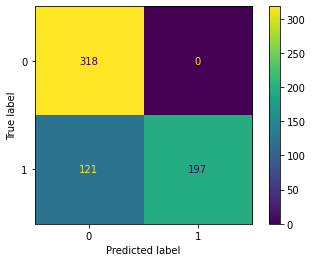

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [63]:
import statistics 
length=57
mode_pred=[]
mode_real=[]
for i in range(0,len(test_df2)-length, length):
    chunk=test_df2.iloc[int(i):int(i+length)]
    # print(list(chunk.columns))
    if(len(chunk['file'].unique())==1):
        chunk1 =scaler.fit_transform(chunk.drop(['file','patient','target'], axis=1))
        mode_pred.append(statistics.mode((clf.predict(np.array(chunk1)))))
        # print(y_test[int(block[0]):int(block[1])])
        mode_real.append(statistics.mode(chunk['target']))
    else:
        print(chunk['file'].unique())


[10813 11528]
[11528 12240]
[12240 12958]


In [64]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))

TN:318, FP:0, FN:121, TP:197


In [65]:
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_test, y_pred, average='micro')
auc=sklearn.metrics.roc_auc_score(y_test, y_pred)

print('specificity= {} , sensitivity= {}, f1= {}, auc={}'.format(specificity, sensitivity, f1_score, auc))

specificity= 1.0 , sensitivity= 0.6194968553459119, f1= 0.809748427672956, auc=0.809748427672956


In [66]:
print(mode_pred)
print(mode_real)  
print(list(np.array(mode_pred)-np.array(mode_real)))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-2.0, -2.0, -2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


              precision    recall  f1-score   support

  interictal       0.80      1.00      0.89        12
    preictal       0.00      0.00      0.00         3

    accuracy                           0.80        15
   macro avg       0.40      0.50      0.44        15
weighted avg       0.64      0.80      0.71        15



C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


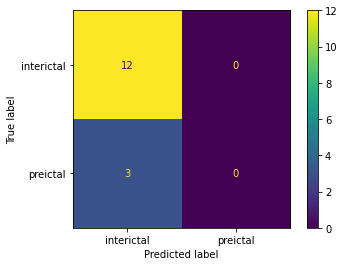

In [67]:
cm = confusion_matrix(mode_real, mode_pred,labels=[0,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interictal', 'preictal'])
disp.plot()
print(sklearn.metrics.classification_report(mode_real, mode_pred, labels=[0,2], target_names=['interictal', 'preictal']))

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf_start = datetime.now()
print(rf_start)


rf = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=70, class_weight='balanced')
rf.fit(Sc_X_train, y_train)
trainAcc=rf.score(Sc_X_train, y_train)
testAcc=rf.score(Sc_X_test, y_test)
print("**Random Forest Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

rf_finish = datetime.now()
rf_time =(rf_finish-rf_start)
print(rf_time)

2021-07-08 21:00:10.280530
**Random Forest Results:**
Training Accuracy: 100%
Testing Accuracy: 59%
0:00:00.402916


In [69]:
rf_y_pred=rf.predict(Sc_X_test)

In [70]:
print(sklearn.metrics.classification_report(y_test, rf_y_pred, labels=[0,2], target_names=['interictal', 'preictal']))

              precision    recall  f1-score   support

  interictal       0.56      0.99      0.71       318
    preictal       0.96      0.21      0.34       318

    accuracy                           0.60       636
   macro avg       0.76      0.60      0.53       636
weighted avg       0.76      0.60      0.53       636



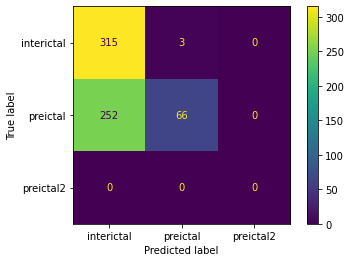

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf_y_pred,labels=[0,2,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interictal', 'preictal', 'preictal2'])
disp.plot()

In [72]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, rf_y_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))

TN:315, FP:3, FN:252, TP:66


In [73]:
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_test, rf_y_pred, average='micro')

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

specificity= 0.9905660377358491 , sensitivity= 0.20754716981132076, f1= 0.5990566037735849


In [74]:
# # print('X size ={}, y size = {}'.format(X_shape, y_shape))
# print('interictal size ={}, preictal size = {}'.format(interictal_shape, preictal_shape))
# print('train size ={}, test size = {}'.format(X_train_shape, X_test_shape))

# print("Training Accuracy: %d"%(trainAcc*100)+"%")
# print("Testing Accuracy: %d"%(testAcc *100)+"%")
# print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
# print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

In [75]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)

lr.fit(Sc_X_train, y_train)
trainAcc = lr.score(Sc_X_train, y_train)
testAcc = lr.score(Sc_X_test, y_test)
print("**SVM Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

**SVM Results:**
Training Accuracy: 99%
Testing Accuracy: 95%


C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       318
         2.0       0.99      0.91      0.95       318

    accuracy                           0.95       636
   macro avg       0.95      0.95      0.95       636
weighted avg       0.95      0.95      0.95       636



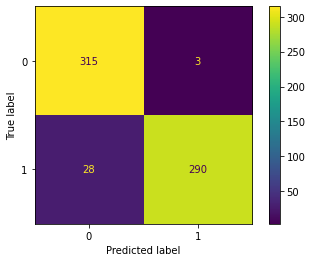

In [76]:
lr_y_pred=lr.predict(scaler.fit_transform(X_test))
print(sklearn.metrics.classification_report(y_test, lr_y_pred))

cm = confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [77]:
# def f_importances(coef, names):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()
# f_importances(clf.coef_, generate_column_names())

In [78]:
# stop

# Testing on a new patient

In [79]:
# df10=pd.DataFrame(data=X_10, columns=generate_column_names())
df10=df[df['patient']==9]
df10=df10[(df10['target']==2) | (df10['target']==0) ]
# df10['target']=y_10
# print(df10.shape)
# df10=df10.dropna()
# print(df10.shape)
# df10.reset_index(drop=True, inplace=True)
# df10=df10[(df10['target']==0) | (df10['target']==2)]
# print(df10['target'].max())
# df10=df10[(df10['patient']==10) ]
df10
# X_10_test  =np.array(test_df[df.columns[-1]]).astype('float32')


,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,patient,day,night,target,file


In [80]:
df10['patient'].unique()

array([], dtype=float64)

In [81]:
df10=df10.drop(['patient'], axis=1)

In [82]:
df10[df10.drop('target', axis=1).columns]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,FT10-T8-2,FT10-T8-3,FT10-T8-4,FT10-T8-5,FT10-T8-6,FT10-T8-7,FT10-T8-8,day,night,file


In [83]:
X_10_test  =np.array(df10.drop('target', axis=1)).astype('float32')
y_10_test  =np.array(df10['target']).astype('float32')


In [84]:
test_10=clf.predict(X_10_test)
test_10.shape

ValueError: Found array with 0 sample(s) (shape=(0, 201)) while a minimum of 1 is required.

In [ ]:
tes_10_score = clf.score(X_10_test, y_10_test)
tes_10_score

ValueError: Found array with 0 sample(s) (shape=(0, 201)) while a minimum of 1 is required.

In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, test_10).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, test_10,pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

TN:1561, FP:12462, FN:3, TP:403
specificity= 0.11131712187121158 , sensitivity= 0.9926108374384236, f1= 0.06073393112802352


In [ ]:
df_results16=pd.DataFrame({'real':y_10_test, 'predicted':test_10})
df_results16


,real,predicted
0,0.0,2.0
1,0.0,2.0
2,0.0,2.0
3,0.0,2.0
4,0.0,2.0
...,...,...
14424,0.0,2.0
14425,0.0,2.0
14426,0.0,2.0
14427,0.0,2.0


In [ ]:
def smooth(ser):
    window=5
    i=0
    while i < len(ser)-window:
        if ser[i]==ser[i+window]:
            ser[i:i+window]=ser[i]
        i+=1
    return np.array(ser)

In [ ]:
import statistics
def smooth_mode(ser):
    window=11
    i=0
    while i < len(ser)-window:
        ser[i:i+window]=statistics.mode(ser[i:i+window])
        i+=window
    return np.array(ser)

In [ ]:
smooth_pred=smooth(test_10)
smooth_pred

array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)

In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, smooth_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, smooth_pred, pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

TN:1321, FP:12702, FN:0, TP:406
specificity= 0.0942023818013264 , sensitivity= 1.0, f1= 0.060085836909871244


In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, smooth_mode(test_10)).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, smooth_mode(test_10), pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

StatisticsError: no unique mode; found 2 equally common values

In [ ]:
stop

NameError: name 'stop' is not defined

### grid search

In [ ]:
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
balance = [{0:10,2:1}, {0:1,2:1}, {0:1,2:10}, {0:1,2:15}, {0:1,2:20}]
costs=[1.0,10.0,100.0, 150.0,1000.0]
# balance = [{0:1,2:10}, {0:1,2:15}]
# costs=[1.0]
param_grid = dict(C=costs, class_weight=balance)

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_macro')


In [ ]:
grid_result = grid.fit(Sc_X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.986212 using {'C': 100.0, 'class_weight': {0: 1, 2: 10}}
0.958576 (0.004747) with: {'C': 1.0, 'class_weight': {0: 10, 2: 1}}
0.964502 (0.007789) with: {'C': 1.0, 'class_weight': {0: 1, 2: 1}}
0.951377 (0.006678) with: {'C': 1.0, 'class_weight': {0: 1, 2: 10}}
0.948806 (0.005731) with: {'C': 1.0, 'class_weight': {0: 1, 2: 15}}
0.948292 (0.005766) with: {'C': 1.0, 'class_weight': {0: 1, 2: 20}}
0.985702 (0.004929) with: {'C': 10.0, 'class_weight': {0: 10, 2: 1}}
0.984169 (0.005134) with: {'C': 10.0, 'class_weight': {0: 1, 2: 1}}
0.985956 (0.003947) with: {'C': 10.0, 'class_weight': {0: 1, 2: 10}}
0.985956 (0.003947) with: {'C': 10.0, 'class_weight': {0: 1, 2: 15}}
0.985956 (0.003947) with: {'C': 10.0, 'class_weight': {0: 1, 2: 20}}
0.985957 (0.004629) with: {'C': 100.0, 'class_weight': {0: 10, 2: 1}}
0.985957 (0.004629) with: {'C': 100.0, 'class_weight': {0: 1, 2: 1}}
0.986212 (0.004862) with: {'C': 100.0, 'class_weight': {0: 1, 2: 10}}
0.986212 (0.004862) with: {'C': 100.0, 'cla